# Time-resolved pupil analysis

## set-up

### imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# REPO_PATH = 'C:/Users/User/visual_encoding'
DATA_DIRECTORY = r'E:\datasets\allen_vc' #f'E:/datasets/allen_vc/manifest_files'

import sys
sys.path.append('../../')
from allen_vc.epoch_extraction_tools import *
from allen_vc.plots import plot_epochs

print('Packages Imported')

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Packages Imported


### settings

In [2]:
# settings
PF = 50
KERNEL_SIZE = 1*PF

## load and pre-processs example pupil data

In [6]:
manifest_path = os.path.join(DATA_DIRECTORY, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()
sessions = sessions[sessions.get('session_type')=='functional_connectivity']
sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
766640955,2019-10-03T00:00:00Z,744912849,functional_connectivity,133.0,M,wt/wt,842,2233,6,"[MB, APN, NOT, DG, CA1, VISam, nan, PF, TH, LP..."
767871931,2019-10-03T00:00:00Z,753795610,functional_connectivity,135.0,M,wt/wt,713,2231,6,"[MRN, APN, MB, DG, CA1, VISrl, nan, VISam, PO,..."
768515987,2019-10-03T00:00:00Z,754477358,functional_connectivity,136.0,M,wt/wt,802,2217,6,"[MB, APN, NOT, DG, CA1, VISam, nan, Eth, LP, P..."
771160300,2019-10-03T00:00:00Z,754488979,functional_connectivity,142.0,M,wt/wt,930,2230,6,"[SCig, PPT, NOT, SUB, ProS, CA1, VISam, nan, A..."
771990200,2019-10-03T00:00:00Z,756578435,functional_connectivity,108.0,M,wt/wt,546,2229,6,"[APN, MB, DG, CA1, VISam, nan, PO, LP, VISpm, ..."


In [7]:
# import example pupil data
SESSION_ID = 766640955
session = cache.get_session_data(SESSION_ID)
pupil_data = session.get_screen_gaze_data()
pupil_data.head()

,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.16310,0.058795,0.011054,3.969006,-1.626442,14.739801,-6.189063
3.19620,0.058669,0.011164,4.001801,-1.664556,14.852316,-6.332932
3.21337,0.058594,0.011342,4.086463,-1.686111,15.149932,-6.414260
3.24650,0.058705,0.011354,4.085960,-1.687487,15.148002,-6.419451
3.27980,0.058736,0.011374,4.101932,-1.634886,15.210047,-6.220944


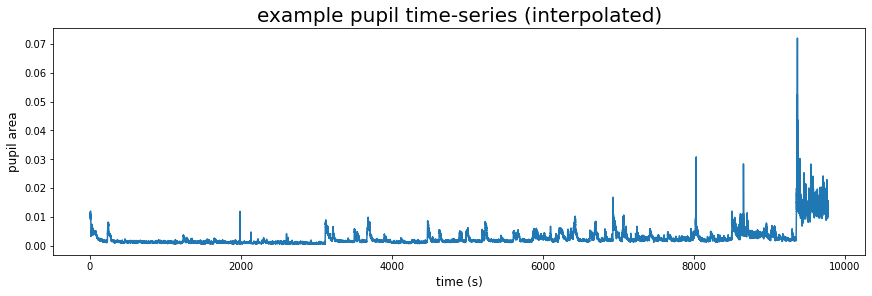

In [13]:
# interpolate pupil data
pupil_data = pupil_data[pupil_data['raw_pupil_area'].notna()]
values = pupil_data['raw_pupil_area']
time_points = pupil_data.index

#Create uniform set of data using interpolation
model = interpolate.interp1d(time_points, values)
time = np.arange(time_points[0], time_points[-1], 1/PF)
area = model(time)

# plot
fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(time, area)
ax.set(xlabel="time (s)", ylabel="pupil area")
ax.set_title("example pupil time-series (interpolated)")
plt.show()

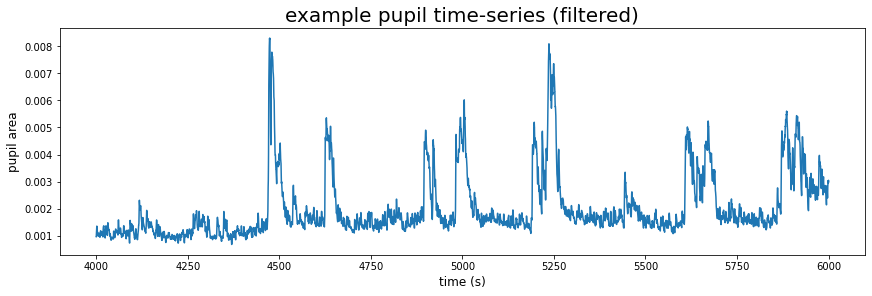

In [12]:
# apply median filter to pupil data
from scipy.ndimage import median_filter

stim_pupil_area = area[(time > 4000) & (time < 6000)] # approx time of spontaneous block
stim_time = time[(time > 4000) & (time < 6000)]
stim_pupil_filt = median_filter(stim_pupil_area, KERNEL_SIZE)

# plot
fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(stim_time, stim_pupil_filt);
ax.set(xlabel="time (s)", ylabel="pupil area")
ax.set_title("example pupil time-series (filtered)")
plt.show()

## epoch pupil data

### dialating v constricting

In [14]:
# settings for epoching (found based on experimentation in epoch_counts.ipynb)
ABOVE_THRESHOLD = 0.0000025
BELOW_THRESHOLD = -0.0000001
MIN_GAP = 0.05
ABOVE_MIN_DURATION = 0.5
BELOW_MIN_DURATION = 2

Signal Start: 4397.968316906174 s


Identified 4912 epochs
Joined 2205 / 4912 epochs
Joined 3837 / 4913 epochs
Dropped 2617 / 2707 epochs
Dropped 641 / 1076 epochs
Identified 3548 epochs
Joined 612 / 3548 epochs
Joined 2004 / 3548 epochs
Dropped 2863 / 2936 epochs
Dropped 1470 / 1544 epochs
Found 90 Above Epochs and 74 Below Epochs



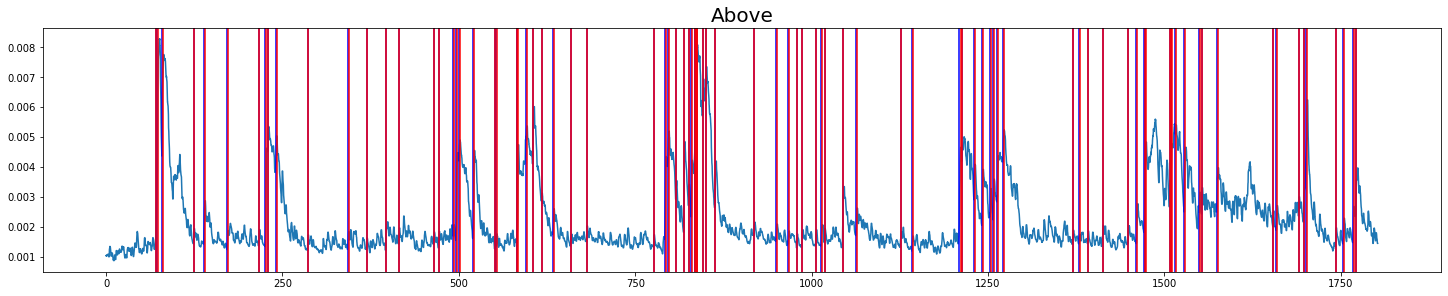

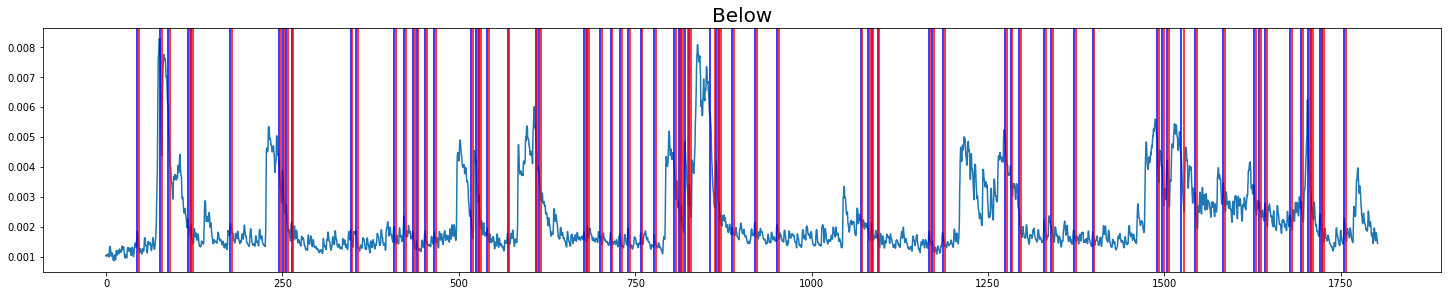

In [15]:
group = pd.read_pickle(f"G:/Shared drives/visual_encoding/data/behavior/pupil/spontaneous/pupil_area_{SESSION_ID}.pkl")
sig =  group.analogsignals[4]
print(f"Signal Start: {sig.t_start}\n\n")
area_deriv = np.diff(sig.magnitude.T[0])
above, _ = get_epoch_times(area_deriv, ABOVE_THRESHOLD, MIN_GAP, ABOVE_MIN_DURATION, PF)
_, below = get_epoch_times(area_deriv, BELOW_THRESHOLD, MIN_GAP, BELOW_MIN_DURATION, PF)

print(f'Found {len(above)} Above Epochs and {len(below)} Below Epochs\n')

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, above)
plt.title("Above")

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, below)
plt.title("Below");

In [16]:
# average length of above epochs (dilation)
np.mean(above[:,1] - above[:,0])

0.8295555555555593

In [17]:
# average length of below epochs (constriction)
np.mean(below[:,1] - below[:,0])

2.628648648648637

In [18]:
above_split = split_epochs(above, 0.7)
below_split = split_epochs(below, 2)

### high arounsal v low arousal

In [36]:
# settings for epoching 
MIN_GAP = 1
MIN_DURATION = 30

Signal Start: 4397.968316906174 s


Identified 46 epochs
Joined 12 / 46 epochs
Joined 6 / 47 epochs
Dropped 26 / 34 epochs
Dropped 32 / 41 epochs
Found 8 Above Epochs and 9 Below Epochs



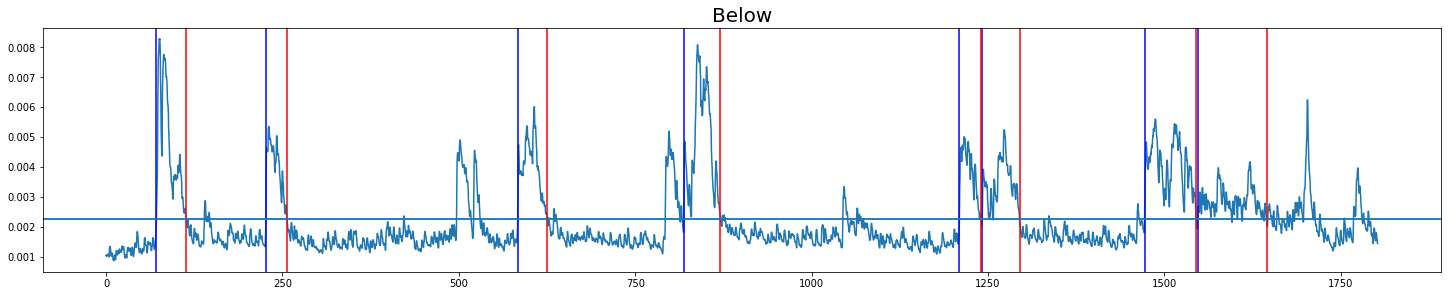

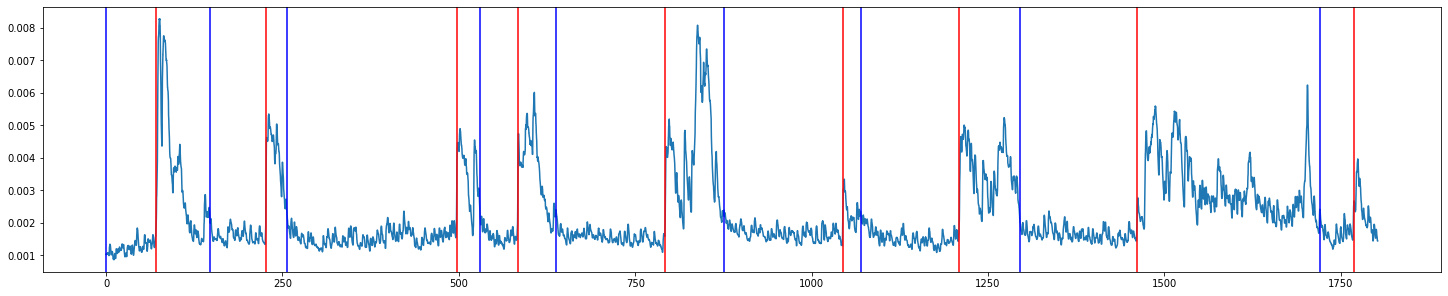

In [37]:
# get example signal
group = pd.read_pickle(f"G:/Shared drives/visual_encoding/data/behavior/pupil/spontaneous/pupil_area_{SESSION_ID}.pkl")
sig =  group.analogsignals[4]
print(f"Signal Start: {sig.t_start}\n\n")

# set params
thresh = np.mean(sig) #+ (1 * np.std(sig))

# epoch
above, below = get_epoch_times(sig, thresh, MIN_GAP, MIN_DURATION, PF)

print(f'Found {len(above)} Above Epochs and {len(below)} Below Epochs\n')

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, above)
ax = plt.gca()
ax.axhline(thresh)
ax.set_title("Above")

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, below)
ax.axhline(thresh)
ax.set_title("Below");

## Time-resolved FFT of LFP to extract parameters for shorter epochs

In [38]:
from allen_vc.allen_utils import find_probes_in_region, align_lfp

In [39]:
probe_id = find_probes_in_region(session, 'VISp')[0][0]
lfp = session.get_lfp(probe_id)

In [40]:
chan_ids = session.channels[(session.channels.probe_id==probe_id) & \
                    (session.channels.ecephys_structure_acronym=='VISp')].index.values

In [41]:
lfp_spont = lfp.sel(time=slice(4000, 6000)).sel(channel=slice(np.min(chan_ids), np.max(chan_ids)))
lfp_spont

<xarray.DataArray 'LFP' (time: 2499999, channel: 22)>
array([[ 3.51195e-04,  4.02285e-04,  3.41640e-04, ...,  2.53500e-05,
         9.55500e-06, -1.07250e-05],
       [ 3.55875e-04,  3.98970e-04,  3.25845e-04, ...,  2.24250e-05,
         7.99500e-06, -1.15050e-05],
       [ 3.61140e-04,  3.97995e-04,  3.41250e-04, ...,  2.04750e-05,
         7.99500e-06, -1.44300e-05],
       ...,
       [-2.76900e-05, -3.62700e-05, -5.03100e-05, ...,  2.73000e-06,
         0.00000e+00,  6.24000e-06],
       [-4.48500e-05, -4.95300e-05, -5.81100e-05, ..., -3.51000e-06,
         2.73000e-06,  0.00000e+00],
       [-4.17300e-05, -4.27050e-05, -6.76650e-05, ..., -5.46000e-06,
         3.31500e-06,  1.75500e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 4e+03 4e+03 4e+03 4e+03 ... 6e+03 6e+03 6e+03 6e+03
  * channel  (channel) int64 850025318 850025326 ... 850025478 850025486

In [42]:
raw_lfp = lfp_spont.values
lfp_swapped = np.swapaxes(raw_lfp, 0 ,1)

In [44]:
# now we do time resolved fft!
import mne.time_frequency as mtf
from time import time as timer

In [ ]:
# choose random time frame for experimentation
lfp_cropped = lfp_swapped[:,:10000]

In [ ]:
t_start = timer()
psd = mtf.tfr_array_multitaper(np.array([lfp_cropped]),sfreq=1250,freqs=np.arange(1,30), output='power', verbose=True)
print(timer() - t_start)

1.4261701107025146


In [26]:
psd.shape # (n_epochs, n_chans, n_freqs, n_times)

(1, 22, 29, 10000)

In [27]:
import seaborn as sns

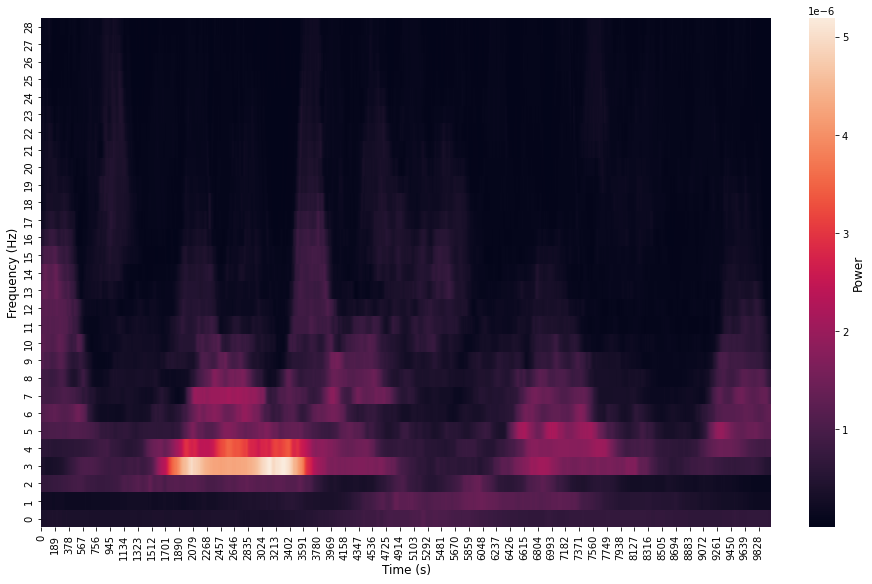

In [28]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(psd[0,0,:,:], cbar_kws={'label': 'Power'});
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)');
ax.invert_yaxis()

In [ ]:
# now perform the analyses for every constriction/dilation epoch

In [59]:
# form arrays including each epoch

lfp_epochs = []

for epoch in (np.array(above_split) + float(sig.t_start)):
    
    lfp_epochs.append(lfp.sel(time=slice(epoch[0], 
                    epoch[1])).sel(channel=slice(np.min(chan_ids), 
                    np.max(chan_ids))).values)

above_lfp_epoched = np.swapaxes(np.array(lfp_epochs),1,2)

lfp_epochs = []

for epoch in (np.array(below_split) + float(sig.t_start)):
    
    lfp_epochs.append(lfp.sel(time=slice(epoch[0], 
                    epoch[1])).sel(channel=slice(np.min(chan_ids), 
                    np.max(chan_ids))).values)
    
below_lfp_epoched = np.swapaxes(np.array(lfp_epochs),1,2)

In [67]:
# 875 time points for above, 2500 for below (limits frequency range that can be observed)

above_lfp_epoched.shape, below_lfp_epoched.shape

((60, 22, 875), (77, 22, 2500))

In [84]:
# 
freq_range = np.arange(10,100)

dilation_mt = mtf.tfr_array_multitaper(above_lfp_epoched,sfreq=1250,freqs=freq_range, output='power', verbose=True)
constriction_mt = mtf.tfr_array_multitaper(below_lfp_epoched,sfreq=1250,freqs=freq_range, output='power', verbose=True)

In [85]:
dilation_mt.shape # epoch, channel, freqs, time points

(60, 22, 90, 875)

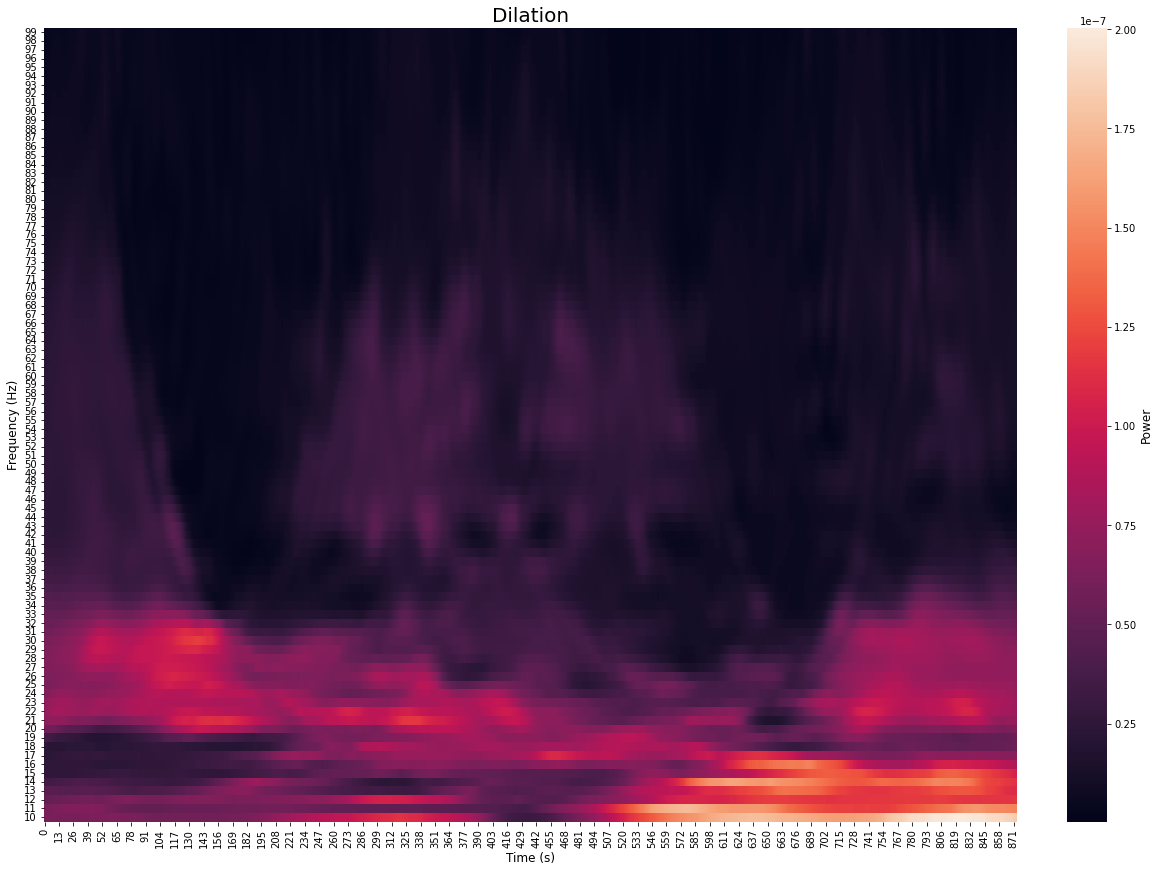

In [100]:
# look at an arbitrary dilation vs constriction epoch

plt.figure(figsize=(16,12))
ax = sns.heatmap(dilation_mt[20,0,:,:], cbar_kws={'label': 'Power'}, yticklabels=freq_range)
plt.title('Dilation')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
ax.invert_yaxis();

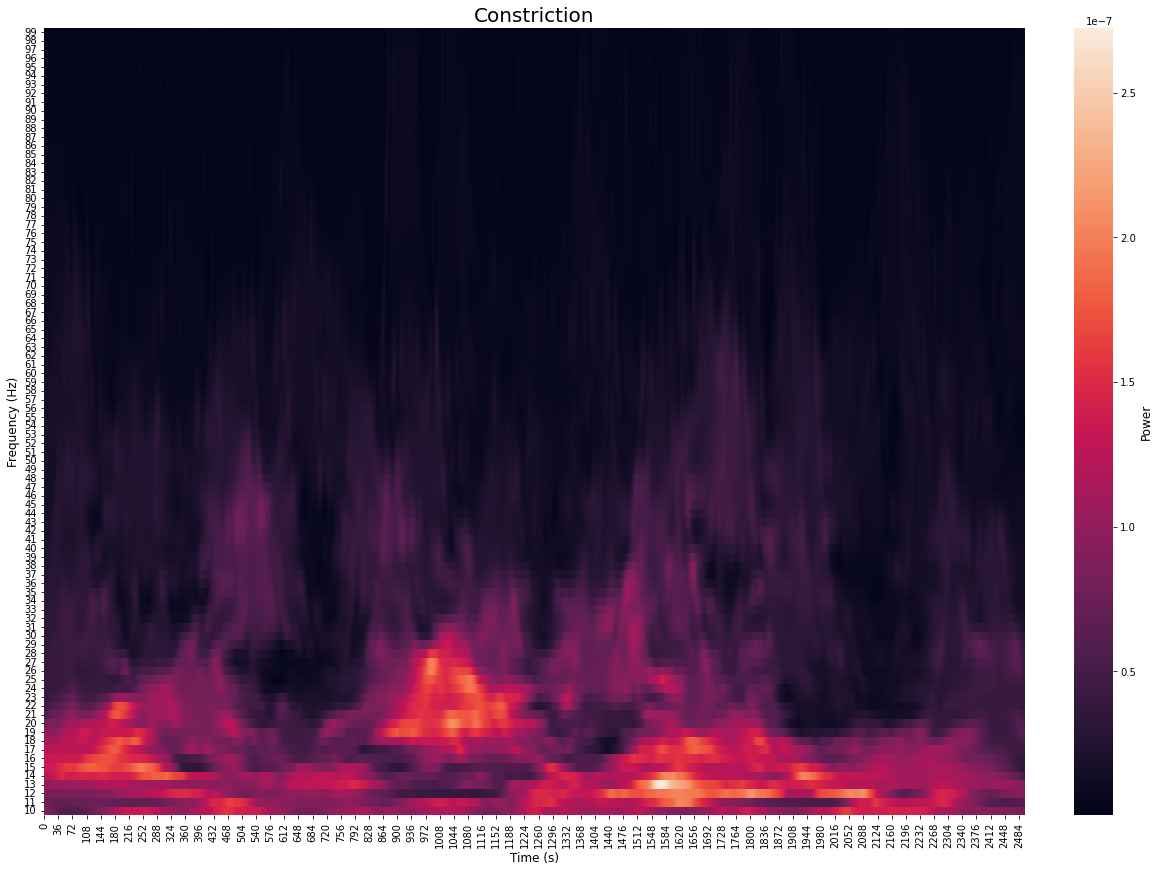

In [98]:
plt.figure(figsize=(16,12))
ax = sns.heatmap(constriction_mt[20,0,:,:], cbar_kws={'label': 'Power'}, yticklabels=freq_range)
plt.title('Constriction')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
ax.invert_yaxis();

# LFP Parameter Temporal Correlations

### SET PATH

In [1]:
# settings
# REPO = 'C:/Users/User/visual_encoding'
DATA = 'G:/Shared drives/visual_encoding/data'

### Imports

In [2]:
import pandas as pd
import numpy as np
import neo
import quantities as pq
import matplotlib.pyplot as plt
import sys
import os
from time import time as timer
sys.path.append('../..')

from allen_vc.plots import plot_linregress, sync_plot
from allen_vc.utils import print_time_elapsed

print("Packages Imported")

Packages Imported


In [3]:
%load_ext autoreload
%autoreload 2

### load results

In [4]:
# concatenate param data
dfs = []
for file in os.listdir(f'{DATA}/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session'):
    dfs.append(pd.read_csv(f'{DATA}/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session/{file}'))

all_chans = pd.concat(dfs)

FYI: The above results can typically be imported directly '<project_path>/lfp_data/params/tfr/<stim_code>/lfp_params.csv'

In [5]:
# median across channels
params = all_chans.groupby(['session', 'epoch_idx', 'window_idx']).median().drop(['chan_idx'], axis=1).reset_index()

In [6]:
params.head()

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,1.385570,3.384751,118.799761,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,1.274334,3.202332,118.969208,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,1.235087,7.364720,122.320409,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,1.214822,8.454238,118.174816,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,1.201398,7.115478,118.733133,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060


### compute instantaneous spike rate and pupil area

In [7]:
# # use sliding window with same window size used for param calculation
# window_size = 0.02*pq.s

# # init - add results to params dataframe
# params['inst_spike_rate'] = np.nan
# params['avg_pupil_area'] = np.nan

# # time it
# start = timer()

# # loop over sessions
# for i_ses, ses_id in enumerate(params['session'].unique()):
#     print(f"Computing session: {ses_id} ({i_ses+1}/{len(params['session'].unique())})")

#     # load session data
#     block = neo.io.NeoMatlabIO(f'{DATA}/blocks/segmented/natural_movie_one_more_repeats/block_{ses_id}.mat').read_block()
#     seg = block.segments[0]
    
#     # init
#     seg_rates = np.empty((len(seg.spiketrains),0))
#     seg_pupil_area = []
#     i = seg.annotations['stimulus_onset']*pq.s
    
#     # loop over sliding window
#     while i <= seg.t_stop - window_size:
        
#         # calculate average pupil area over window
#         if len(seg.analogsignals) > 1:
#             seg_pupil_area.append(np.mean(seg.analogsignals[1].time_slice(i, i+window_size)))
#         else:
#             seg_pupil_area.append(np.nan)
        
#         # calculate spike train rates for each unit over window
#         train_rates = []
#         for train in seg.spiketrains:
#             train_rates.append(np.sum(train.time_slice(i, i+window_size) > 0)/window_size)
#         seg_rates = np.hstack((seg_rates, np.array([train_rates]).T))
        
#         # increment window
#         i += window_size

#     # add segment data to params dataframe
#     params.loc[params['session']==ses_id, 'inst_spike_rate'] = np.mean(seg_rates, axis=0)
#     params.loc[params['session']==ses_id, 'avg_pupil_area'] = seg_pupil_area

# # save/show results
# params.to_csv(f'{DATA}/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params.csv', index=False)
# print_time_elapsed(start)
# params.head()

In [24]:
# load results from cell above
fname_in = f'{DATA}/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params.csv'
params = pd.read_csv(fname_in)
params


,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,118.799761,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,6.640625,0.002671
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,118.969208,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,7.812500,0.002669
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,122.320409,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,12.109375,0.002682
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,118.174816,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,9.765625,0.002681
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,118.733133,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,9.765625,0.002670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34495,847657808,1,1495,-4.857810,11.010139,2.056443,31.123661,1.281020,7.864390,41.984415,...,59.685927,1.294906,4.984053,141.740863,1.078924,4.364880,0.342187,0.837337,3.000000,0.001058
34496,847657808,1,1496,-4.933897,9.724433,1.995245,24.422391,1.220671,9.837652,32.881799,...,43.024776,1.235365,3.877665,144.994872,1.054585,17.889248,0.356551,0.834566,16.000000,0.001041
34497,847657808,1,1497,-4.979816,9.229342,2.063792,27.270827,1.241427,7.709048,34.092404,...,57.674647,1.194255,4.586702,136.171299,1.089705,17.912987,0.326235,0.845878,12.000000,0.001041
34498,847657808,1,1498,-5.259292,4.173838,2.011628,26.267412,1.272173,6.178514,34.354733,...,66.877455,1.228644,5.856120,95.127245,1.074671,17.476757,0.317936,0.851855,19.000000,0.001025


### plot results

In [9]:
# # plot time-series

# # scale vars for visualization
# exponent_scaled = params['exponent'] / np.mean(params['exponent']) * np.mean(params['avg_pupil_area'])
# rate_scaled = params['inst_spike_rate'] / np.mean(params['inst_spike_rate']) * np.mean(params['avg_pupil_area'])

# # plot
# fig, ax = plt.subplots(1,1, figsize=[12,4])
# ax.plot(params['avg_pupil_area'], alpha=0.8, label='pupil area')
# ax.plot(exponent_scaled, alpha=0.8, label='exponent')
# ax.plot(rate_scaled, alpha=0.2, label='spike rate')
# ax.set(xlabel="", ylabel="")
# ax.set_title("")
# ax.legend()
# plt.show()

In [25]:
# check 'avg_pupil_area' and'inst_spike_rate' columns of params for nan values
print(params['avg_pupil_area'].isna().sum())
print(params['inst_spike_rate'].isna().sum())
params.loc[params['avg_pupil_area'].isna()]

3000
0


,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area
3000,768515987,1,0,-3.372147,177.523089,2.835724,121.826157,1.124589,20.000000,129.587062,...,152.639326,1.116878,16.222767,190.864466,1.179439,7.600289,0.304561,0.895038,8.750000,NaN
3001,768515987,1,1,-3.401916,120.156340,2.789171,90.627863,1.145285,10.342465,128.463508,...,161.292719,1.070284,15.745611,190.831094,1.165578,8.007800,0.310270,0.905918,7.916667,NaN
3002,768515987,1,2,-3.512564,79.249395,2.684777,59.674804,1.185786,8.516387,126.790340,...,161.050070,1.142576,16.050119,191.065156,1.179409,11.488575,0.310528,0.914241,7.916667,NaN
3003,768515987,1,3,-3.617016,75.770055,2.735336,65.180756,1.169016,6.287032,127.485857,...,150.351047,1.168781,16.548301,190.100955,1.179461,9.177705,0.323699,0.896471,7.916667,NaN
3004,768515987,1,4,-4.052856,26.807819,2.603649,27.123797,1.138909,5.390279,101.127497,...,146.883872,1.035586,20.000000,191.225058,1.120913,11.257217,0.327656,0.896981,11.250000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,840012044,1,1495,-6.489001,-1.092550,1.245279,9.342574,1.181797,5.001358,23.618601,...,56.490487,1.368750,10.140499,87.068577,1.418706,3.863567,0.350827,0.759301,11.956522,NaN
32996,840012044,1,1496,-5.970532,1.210855,1.463460,19.806080,1.221256,6.129567,49.426064,...,59.047357,1.570325,4.269359,121.327655,1.341377,19.450778,0.349446,0.752852,7.608696,NaN
32997,840012044,1,1497,-6.033599,-0.459976,1.425975,19.270788,1.261938,4.948023,42.362817,...,58.952317,1.386698,6.318769,100.085100,1.302228,19.998882,0.337796,0.754299,9.782609,NaN
32998,840012044,1,1498,-5.908857,1.662053,1.464892,21.287663,1.012716,18.746320,55.290385,...,59.473751,1.376285,8.073376,103.419348,1.252666,15.170851,0.350802,0.755884,9.782609,NaN


In [26]:
# drop subjects with no pupil data
full_params = params.dropna(axis=0,subset=['avg_pupil_area', 'inst_spike_rate'])

<AxesSubplot:ylabel='Density'>

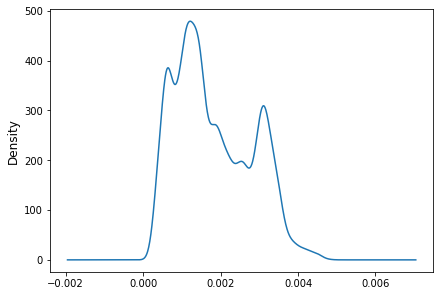

In [27]:
full_params['avg_pupil_area'].plot(kind='kde')

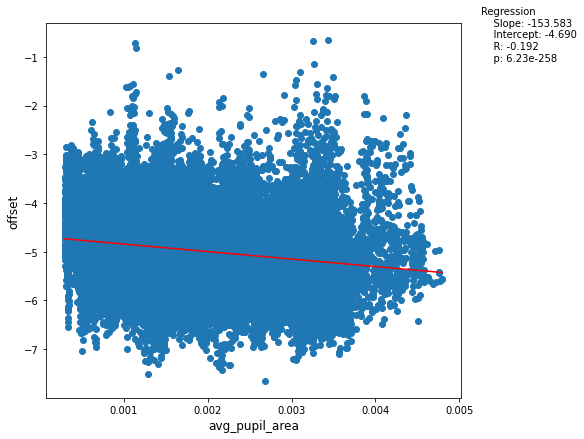

In [28]:
plot_linregress(full_params, 'avg_pupil_area', 'offset', show=True) 

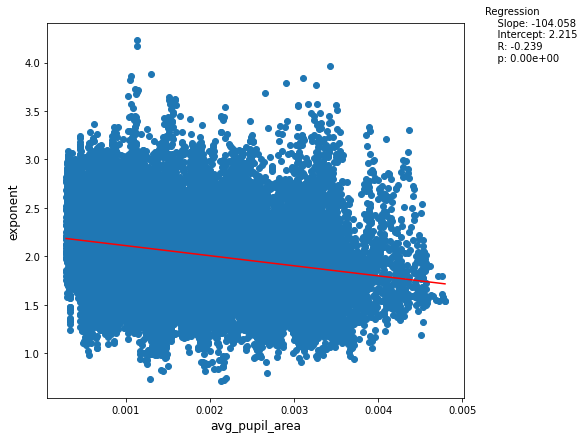

In [29]:
plot_linregress(full_params, 'avg_pupil_area', 'exponent', show=True) 

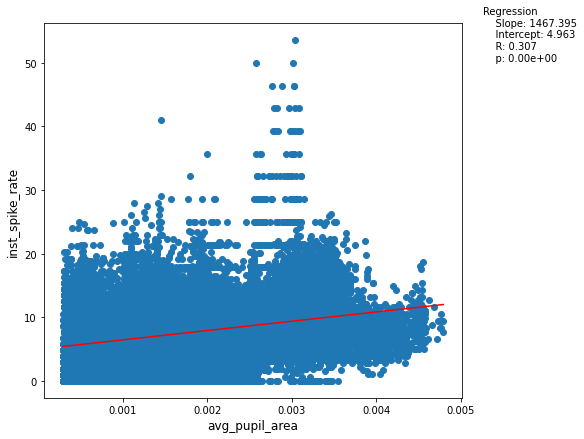

In [30]:
plot_linregress(full_params, 'avg_pupil_area', 'inst_spike_rate', show=True) 

#### plot each subject

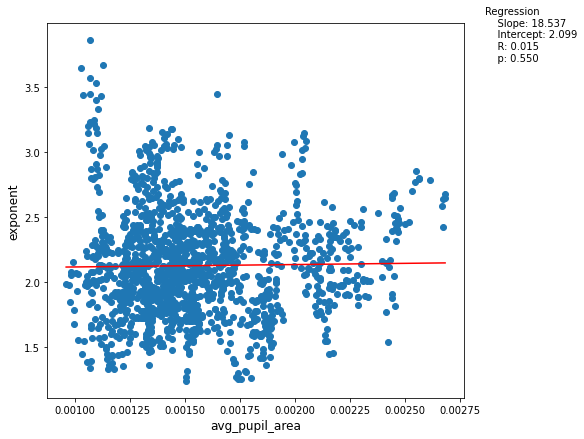

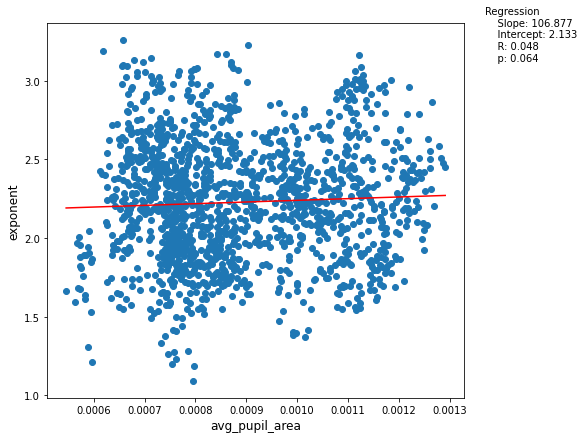

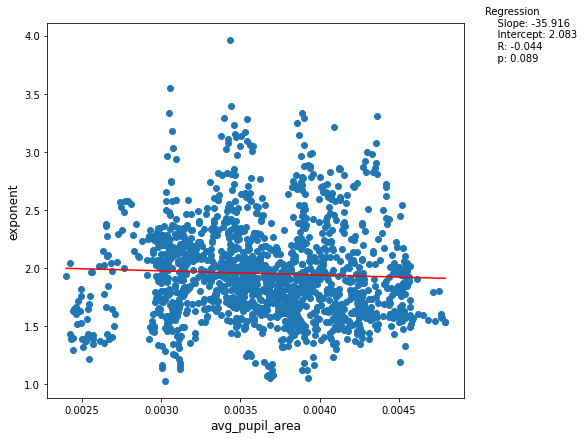

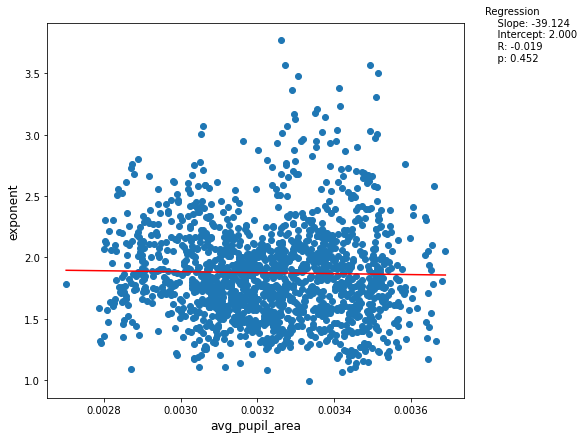

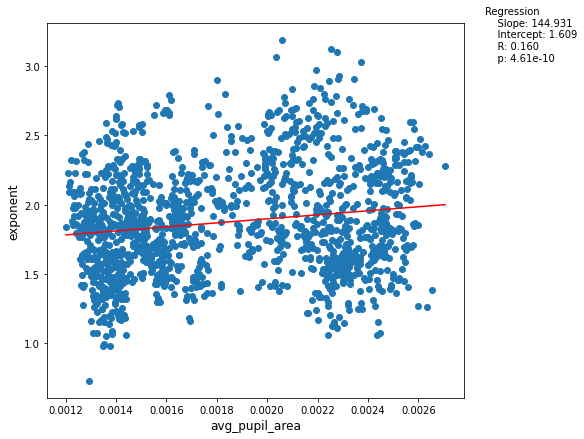

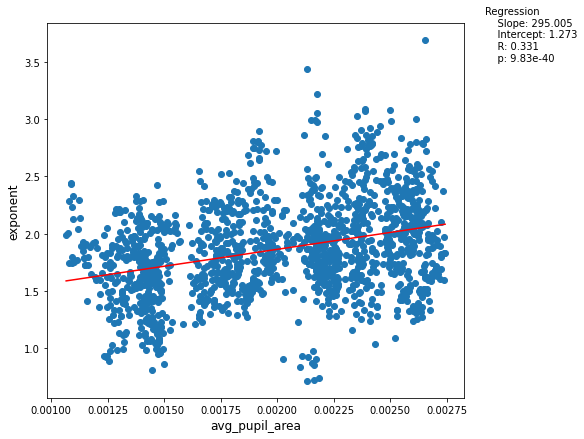

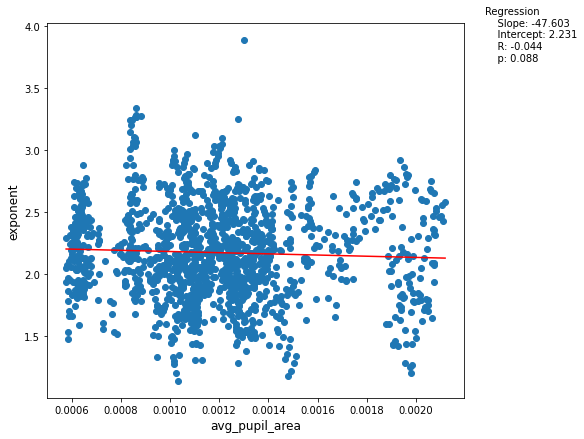

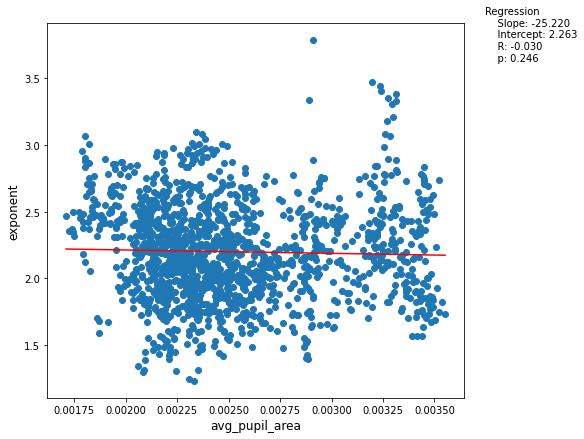

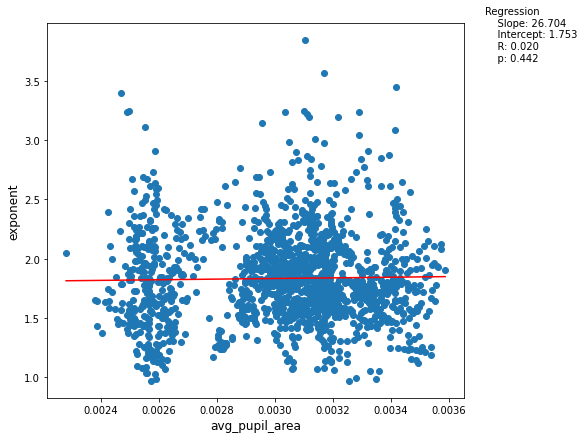

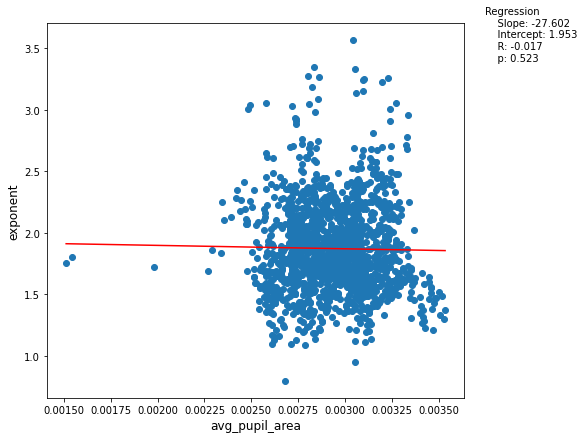

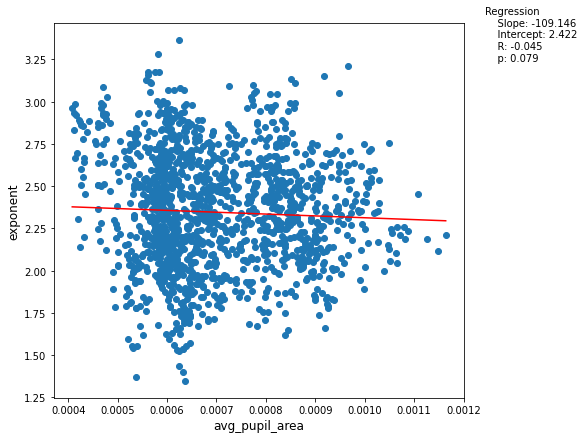

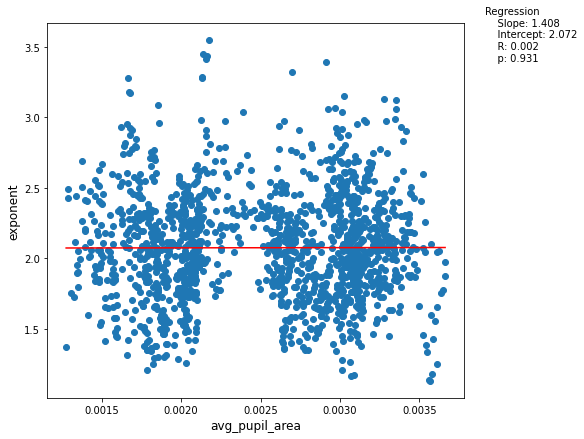

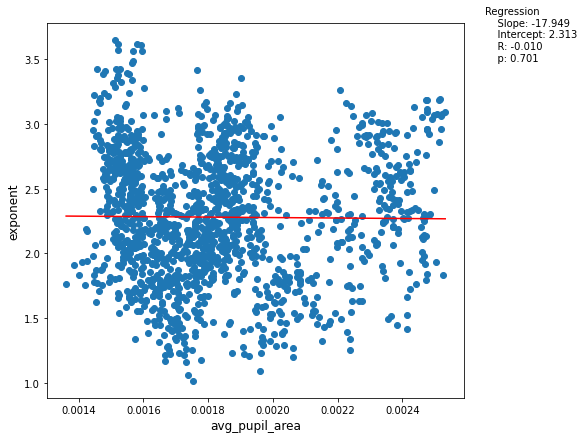

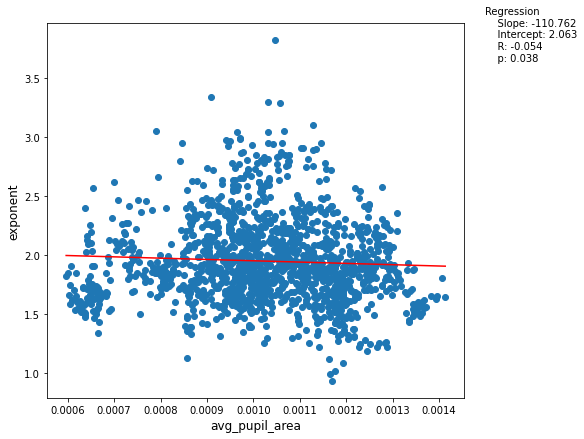

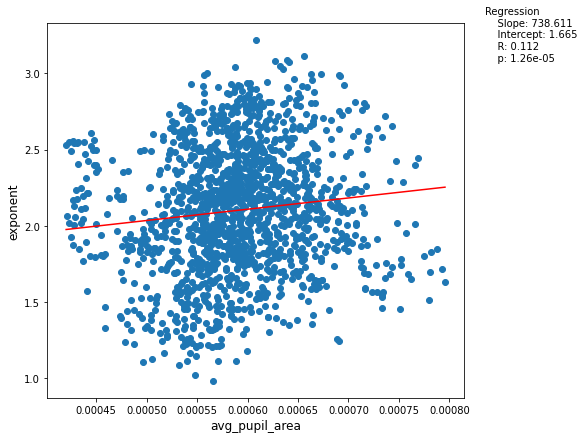

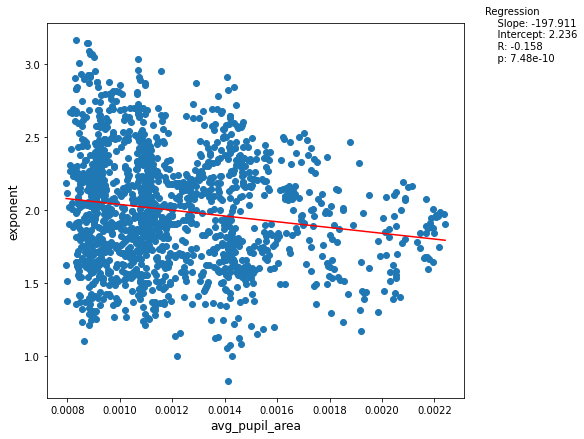

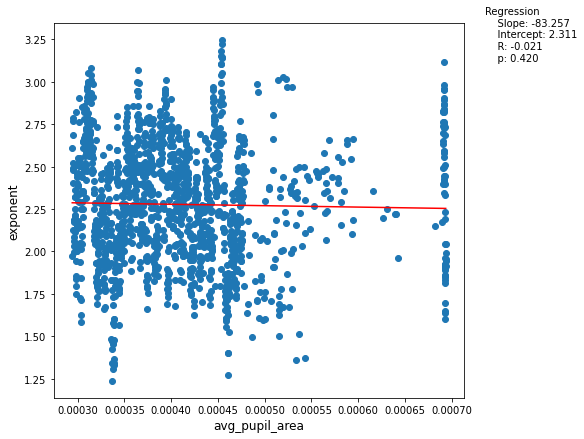

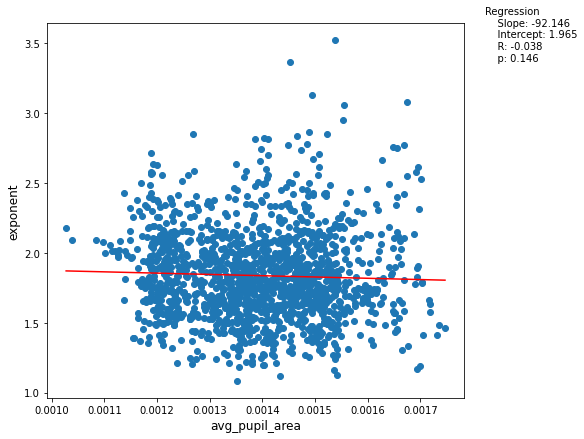

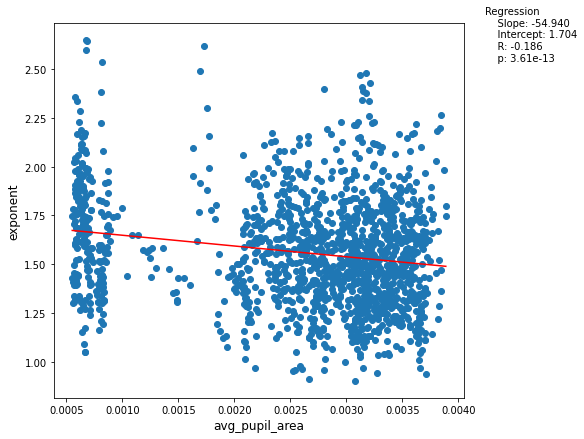

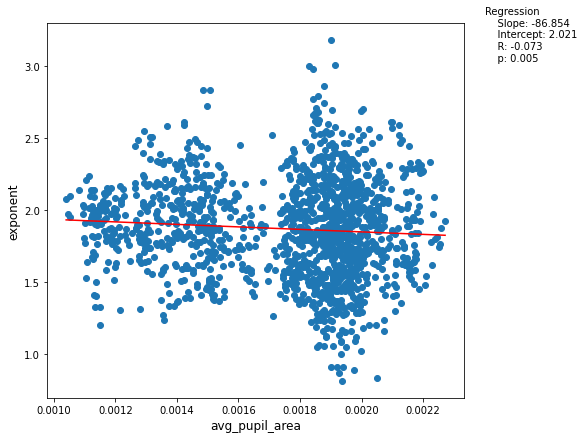

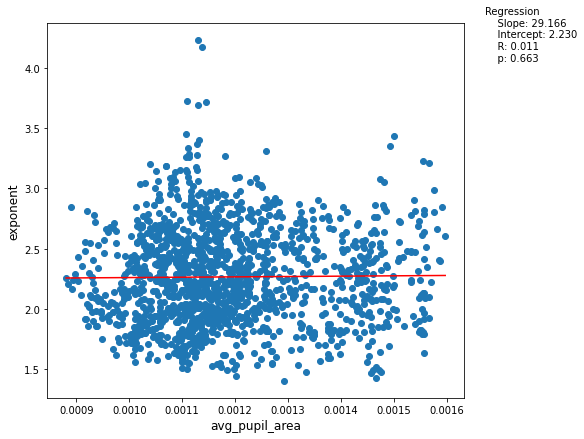

In [39]:
for i_session, session in enumerate(full_params['session'].unique()):
    df = full_params[full_params['session'] == session]
    plot_linregress(df, 'avg_pupil_area', 'exponent', show=True)
